In [1]:
# supress tensorflow warnings and info
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import multiprocessing as mp
import time

import numpy as np
import pandas as pd
import tensorflow_text

from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [3]:
import tensorflow as tf

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow_hub as hub

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
# preprocess untranslated dataset
df_cdp_multi = pd.read_csv('csvs/cdp_clean.csv', sep=',').drop(columns=['Unnamed: 0'])[['area', 'title+desc']]

area_energy = (df_cdp_multi['area'] == 'energy efficiency / retrofit') | (df_cdp_multi['area'] == 'energy efficiency (including public lighting)')
df_cdp_multi.loc[area_energy, 'area'] = 'energy efficiency'

area_waste = df_cdp_multi['area'] == 'waste management (including waste recycling)'
df_cdp_multi.loc[area_waste, 'area'] = 'waste management'

min_sample_count = 100
area_count = pd.DataFrame(df_cdp_multi.value_counts(subset='area')).rename(columns={0: 'sample_count'})
areas_to_keep = area_count[area_count > min_sample_count].dropna().index.to_list()
area_filter = df_cdp_multi['area'].isin(areas_to_keep)
df_clean_multi = df_cdp_multi[area_filter]
df_clean_multi

,area,title+desc
0,energy efficiency,intensity control of led light points for high...
1,waste management,instalación de planta trituradora de llantas. ...
2,transport,seguimiento y control ambiental a tecnologías ...
3,waste management,fortalecimiento programa de reciclaje inclusiv...
4,waste management,waste to energy project for blantyre city. reh...
...,...,...
1300,energy efficiency,decarbonisation of local authority maintained ...
1301,buildings,charlotte & william bloomberg public library. ...
1302,energy efficiency,bloomington green home improvement program. th...
1303,water management,greater amman municipality (gam) - saqef al se...


In [6]:
param_sets = [
    # model_type, hidden_neurons, epochs
    (True, 'use-multi', 24, (25, 3))
]

In [7]:
# selecting the parameters
multilingual, model_type, hidden_neurons, epochs = param_sets[0]

In [8]:
# x is input, y is output
df_dataset = df_clean_multi
x = df_dataset['title+desc'].to_numpy()
y = df_dataset['area'].to_numpy()

# one hot encode the output
label_binarizer = LabelBinarizer()
y_e = label_binarizer.fit_transform(y)

In [9]:
# split the dataset into train, test and val
x_train, x_valtest, y_train, y_valtest = train_test_split(x, y_e, test_size=0.30, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.5, random_state=42)

In [10]:
# function that implements the model creation, training and deletion
def fit_keras(x_train,
              y_train,
              x_val,
              y_val,
              classes,
              model_type,
              hidden_neurons,
              epochs):
    
    # bring pre-trained model from tf hub as a layer
    if model_type == 'nnlm50':
        hub_layer = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2', input_shape=[], dtype=tf.string)
    elif model_type == 'nnlm128':
        hub_layer = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2', input_shape=[], dtype=tf.string)
    elif model_type == 'use':
        hub_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', input_shape=[], dtype=tf.string)
    elif model_type == 'use-multi':
        hub_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', input_shape=[], dtype=tf.string)

    # create the model with the parameters given
    # model = tf.keras.Sequential()
    # model.add(hub_layer)
    # if hidden_neurons > 0:
    #     model.add(tf.keras.layers.Dropout(0.2))
    #     model.add(tf.keras.layers.Dense(hidden_neurons, activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.2))
    # model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    inputs = tf.keras.Input(shape=[], dtype=tf.string)
    x = hub_layer(inputs, training=False)
    if hidden_neurons > 0:
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(hidden_neurons, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    # enable tensorboard visualizations
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

    # enable early stopping
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=[tf.metrics.CategoricalAccuracy()])

    # finally, fit the model on the data given
    history_tf = model.fit(x_train,
                        y_train,
                        epochs=epochs[0],
                        batch_size=32,
                        validation_data=[x_val, y_val],
                        verbose=1,
                        callbacks=[tensorboard_callback, early_stopping_callback])
    
    # set hub layer to trainable
    hub_layer.trainable = True
    
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=[tf.metrics.CategoricalAccuracy()])

    # finally, fit the model on the data given
    history_ft = model.fit(x_train,
                        y_train,
                        epochs=epochs[1],
                        batch_size=32,
                        validation_data=[x_val, y_val],
                        verbose=1,
                        callbacks=[tensorboard_callback, early_stopping_callback])

    # return model
    return model, history_tf, history_ft

In [11]:
# train a model
model, history_tf, history_ft = fit_keras(x_train=x_train,
                                          y_train=y_train,
                                          x_val=x_val,
                                          y_val=y_val,
                                          classes=np.unique(y),
                                          model_type=model_type,
                                          hidden_neurons=hidden_neurons,
                                          epochs=epochs)

Epoch 1/25
26/26 [==============================] - 9s 75ms/step - loss: 1.7364 - categorical_accuracy: 0.3889 - val_loss: 1.6653 - val_categorical_accuracy: 0.5460
Epoch 2/25
26/26 [==============================] - 1s 28ms/step - loss: 1.5898 - categorical_accuracy: 0.5568 - val_loss: 1.5114 - val_categorical_accuracy: 0.6379
Epoch 3/25
26/26 [==============================] - 1s 28ms/step - loss: 1.4281 - categorical_accuracy: 0.6321 - val_loss: 1.3642 - val_categorical_accuracy: 0.6782
Epoch 4/25
26/26 [==============================] - 1s 28ms/step - loss: 1.2918 - categorical_accuracy: 0.6494 - val_loss: 1.2392 - val_categorical_accuracy: 0.7011
Epoch 5/25
26/26 [==============================] - 1s 27ms/step - loss: 1.1593 - categorical_accuracy: 0.6778 - val_loss: 1.1301 - val_categorical_accuracy: 0.6954
Epoch 6/25
26/26 [==============================] - 1s 27ms/step - loss: 1.0547 - categorical_accuracy: 0.6988 - val_loss: 1.0431 - val_categorical_accuracy: 0.7414
Epoch 7/25

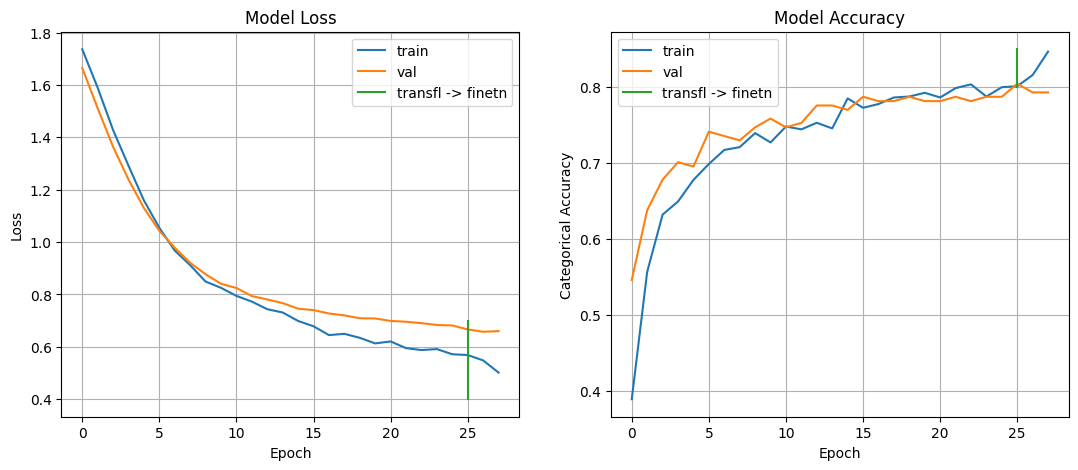

In [12]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(13, 5))

ax_loss.plot(history_tf.history['loss'] + history_ft.history['loss'])
ax_loss.plot(history_tf.history['val_loss'] + history_ft.history['val_loss'])
ax_loss.plot([25, 25], [0.4, 0.7])
ax_loss.set_title('Model Loss')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.legend(['train', 'val', 'transfl -> finetn'])
ax_loss.grid()

ax_acc.plot(history_tf.history['categorical_accuracy'] + history_ft.history['categorical_accuracy'])
ax_acc.plot(history_tf.history['val_categorical_accuracy'] + history_ft.history['val_categorical_accuracy'])
ax_acc.plot([25, 25], [0.8, 0.85])
ax_acc.set_title('Model Accuracy')
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Categorical Accuracy')
ax_acc.legend(['train', 'val', 'transfl -> finetn'])
ax_acc.grid()

In [13]:
# save model
model.save('models/trained_model.h5')

In [14]:
# load model
model = tf.keras.models.load_model('models/trained_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [15]:
# get train accuracy
train_loss, train_acc = model.evaluate(x_train, y_train, batch_size=32)
train_acc

26/26 [==============================] - 1s 16ms/step - loss: 0.4234 - categorical_accuracy: 0.8852


0.885185182094574

In [16]:
# get val accuracy
val_loss, val_acc = model.evaluate(x_val, y_val, batch_size=32)
val_acc

6/6 [==============================] - 0s 15ms/step - loss: 0.6600 - categorical_accuracy: 0.7931


0.7931034564971924

In [17]:
# get test accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=32)
test_acc

6/6 [==============================] - 0s 15ms/step - loss: 0.5997 - categorical_accuracy: 0.7874


0.7873563170433044

In [18]:
p = model.count_params()
print(f'{int(p/1e6)} M')

68 M


In [19]:
# put accuracy results on a table
df_acc = pd.DataFrame({'train': [train_acc], 'val': [val_acc], 'test': [test_acc]}, index=['acc']).T
df_acc

,acc
train,0.885185
val,0.793103
test,0.787356


In [20]:
# print table
print(df_acc.apply(lambda r: f'{r["acc"]:.4f}', axis=1).to_markdown())

|       |      0 |
|:------|-------:|
| train | 0.8852 |
| val   | 0.7931 |
| test  | 0.7874 |


6/6 [==============================] - 1s 15ms/step


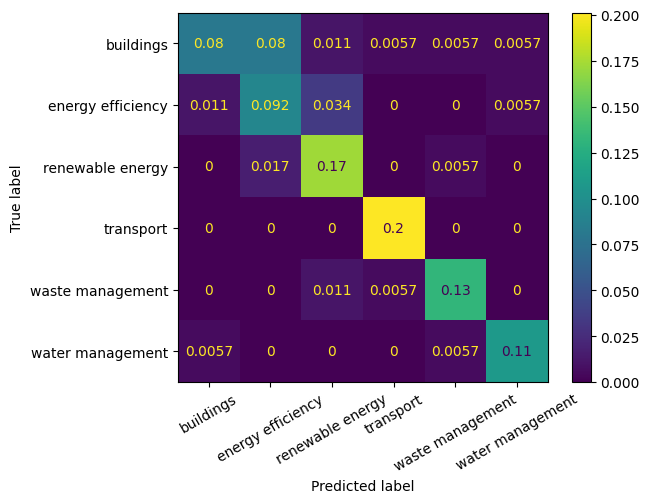

In [21]:
# confusion matrix
y_true = label_binarizer.inverse_transform(y_test)
y_pred = label_binarizer.inverse_transform(model.predict(x_test))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='all', xticks_rotation=30)

In [22]:
label_binarizer.inverse_transform(model.predict(np.array([
    'solar wind farm on the netherlands creating sustainable energy for a small town',
    'sistema de recolhimento de lixo automatizado por caminhões',
    'sistema de tratamento de esgoto'
])))

1/1 [==============================] - 0s 18ms/step


array(['renewable energy', 'waste management', 'water management'],
      dtype='<U17')